# Safety levels

NEN 8700 specifies a number of safety levels, which are essentially reliability indices that a construction must meet:

| Safety level | Assessment level |
|--------------|------------------|
| CC3          | 3.3              |
| CC2          | 2.5              |
| CC1b         | 1.8              |
| CC1a         | 1.8              |


In this example, we will show how to apply the safety levels to assess the bearing capacity of a pile. 

### Define model

First, let's import the necessary packages:

In [1]:
from probabilistic_library import SensitivityProject, DistributionType, SensitivityMethod, StandardNormal
import numpy as np
import matplotlib.pyplot as plt

We use the Koppejan method to calculate the bearing capacity of a pile ($p$).

For this example, we assume there are two soil layers: the top layer is clay, and the bottom layer is sand. The surface level is at 0 m+NAP. The soil has the following characteristics:

| Parameter | Description                          |
|-----------|--------------------------------------|
| z         | Depth at which the sand layer starts |
| q_clay    | CPT resistance in clay layer         |
| q_sand    | CPT resistance in sand layer         |
    
The pile has the following characteristics:

| Parameter | Description         |
|-----------|---------------------|
| D         | Diameter of the pile|
| L         | Length of the pile  |

The Koppejan method is implemented in the following function:

In [2]:
from utils.models import get_bearing_capacity

The bearing capacity of a pile is compared with the applied load, resulting in a unity check value (UC). A UC value greater than $1.0$ indicates failure, meaning the load exceeds the bearing capacity of the pile.

In [3]:
def get_unity_check(load, z, q_clay, q_sand, D, L):
    p = get_bearing_capacity(z, q_clay, q_sand, D, L)
    uc = load / p

    return uc

### Sensitivity analysis

The goal is to calculate the UC values at the safety levels. To achieve this, we conduct a sensitivity analysis. We begin by creating a sensitivity project and defining the model:

In [4]:
project = SensitivityProject()
project.model = get_unity_check
project.model.print()

Model get_unity_check:
Input parameters:
  load
  z
  q_clay
  q_sand
  D
  L
Output parameters:
  uc


### Assign stochastic values

The following values and uncertainties are applied to the variables. The load is derived from a design value and is recalculated as a stochastic variable, as we want to perform a full probabilistic calculation.

In [5]:
project.variables["D"].distribution = DistributionType.normal
project.variables["D"].mean = 0.2
project.variables["D"].deviation = 0.04
project.variables["D"].truncated = True
project.variables["D"].minimum = 0.0
project.variables["D"].maximum = 1.0

project.variables["L"].distribution = DistributionType.normal
project.variables["L"].mean = 12.0
project.variables["L"].deviation = 0.8

project.variables["z"].distribution = DistributionType.normal
project.variables["z"].mean = 10.0
project.variables["z"].deviation = 0.2

project.variables["q_sand"].distribution = DistributionType.log_normal
project.variables["q_sand"].mean = 500.0
project.variables["q_sand"].deviation = 50.0

project.variables["q_clay"].distribution = DistributionType.log_normal
project.variables["q_clay"].mean = 25000.0
project.variables["q_clay"].deviation = 400.0

project.variables["load"].distribution = DistributionType.gumbel
project.variables["load"].design_quantile = 0.95
project.variables["load"].design_factor = 1.0
project.variables["load"].variation = 0.1
project.variables["load"].design_value = 100000.0

print(f"Load = {project.variables["load"].mean} +- {project.variables["load"].deviation}")

Load = 84275.78591160773 +- 8427.578591160775


### Perform calculation 

We peform the sensitivity analysis using `crude_monte_carlo` method:

In [6]:
project.settings.sensitivity_method = SensitivityMethod.crude_monte_carlo
project.settings.maximum_samples = 10000
project.run()
uc_mc = project.stochast

Let's plot the results:

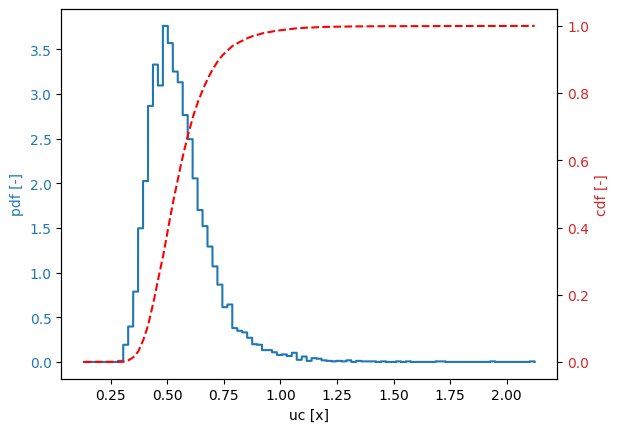

In [7]:
uc_mc.plot()

Next, we derive the values of UC, which correspond to the predefined safety levels. If the UC value for a given safety level is greater than $1.0$, then that safety level is not met.

In [8]:
safety_levels = [1.8, 2.5, 3.3]
safety_levels_txt = ["CC1b", "CC2 ", "CC3 "]

def check_sl(uc, safety_levels, safety_levels_txt):

    for idx, sl in enumerate(safety_levels):
        p = StandardNormal.get_p_from_u(sl)
        uc_sl = uc.get_quantile(p)
        print (f"Safety level ({safety_levels_txt[idx]}):  {sl} => UC = {uc_sl}")

check_sl(uc_mc, safety_levels, safety_levels_txt)

Safety level (CC1b):  1.8 => UC = 0.8564457238247961
Safety level (CC2 ):  2.5 => UC = 1.0979807121952414
Safety level (CC3 ):  3.3 => UC = 1.6925889446516011



We see that the pile construction meets only the safety level CC1b. Safety levels CC2 and CC3 are not met.

### Alternative methods

We can also apply other sensitivity methods e.g. `form`, `importance_sampling` and `directional_sampling`. 

For `directional_sampling`, it is neceessary to predefine the quantiles in which we are interested (the reliability index $3.3$ is not calculated well, therefore another value is used).

Variable uc:
  distribution = cdf_curve
Definition:
  beta[0.1689] = -7.9926
  beta[0.1775] = -7.4938
  beta[0.1868] = -6.9948
  beta[0.197] = -6.4958
  beta[0.2082] = -5.9966
  beta[0.2205] = -5.4973
  beta[0.2341] = -4.9979
  beta[0.2492] = -4.4984
  beta[0.2661] = -3.9988
  beta[0.285] = -3.4992
  beta[0.3064] = -2.9995
  beta[0.3307] = -2.4997
  beta[0.3585] = -1.9998
  beta[0.3907] = -1.4999
  beta[0.4283] = -1.0
  beta[0.4726] = -0.5
  beta[0.5256] = 0.0
  beta[0.59] = 0.5
  beta[0.6695] = 1.0
  beta[0.77] = 1.4998
  beta[0.9009] = 1.9995
  beta[1.078] = 2.4988
  beta[1.3307] = 2.9974
  beta[1.7208] = 3.4948
  beta[2.4037] = 3.9903
  beta[3.9032] = 4.483
  beta[9.1723] = 4.9719
  beta[53.095] = 5.4568
  beta[762.2366] = 5.9405
  beta[15946.244] = 6.4258
  beta[429908.6111] = 6.913
  beta[14811589.3153] = 7.4017
  beta[651159147.8554] = 7.8917
Derived values:
  mean = 0.5521
  deviation = 0.1391
  variation = 0.252
form
Safety level (CC1b):  1.8 => UC = 0.8486364455633592
Safety l

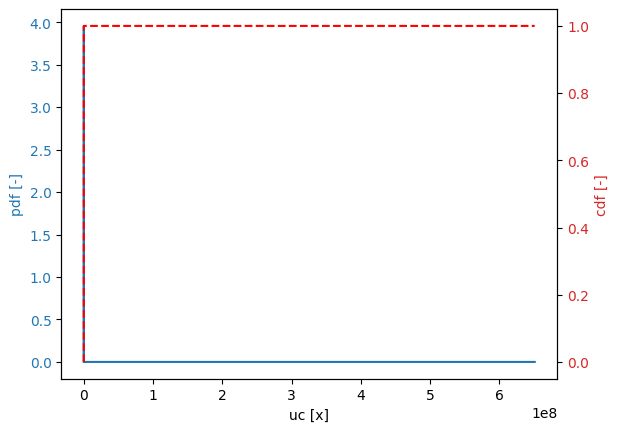

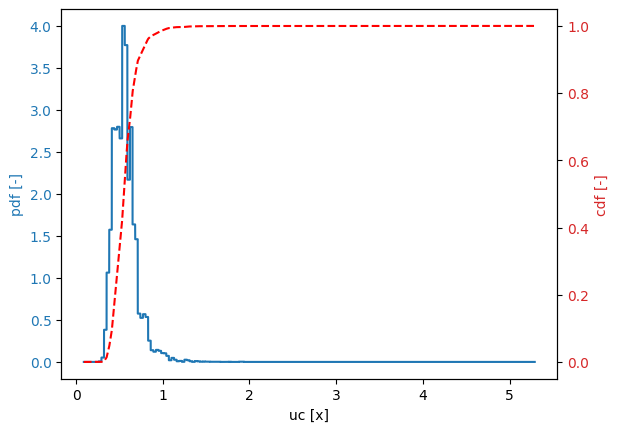

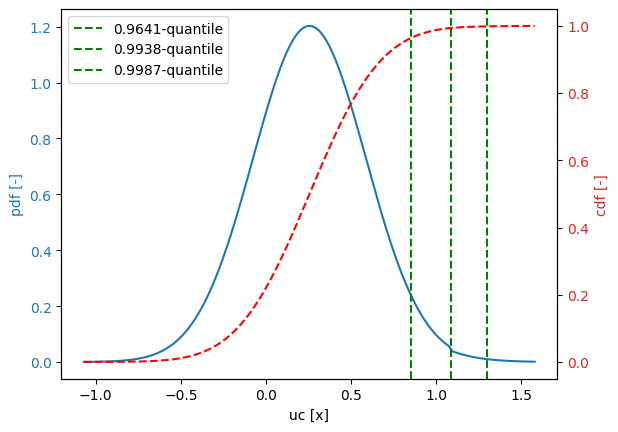

In [9]:
project.settings.sensitivity_method = SensitivityMethod.form
project.run()
project.result.print()

print(project.settings.sensitivity_method)
check_sl(project.result.variable, safety_levels, safety_levels_txt)
project.result.plot()

project.settings.sensitivity_method = SensitivityMethod.importance_sampling
project.settings.maximum_samples = 1000
project.settings.stochast_settings["D"].start_value = -0.5
project.settings.stochast_settings["load"].start_value = 0.5
project.run()
project.result.print()
print(' ')
print(project.settings.sensitivity_method)
check_sl(project.result.variable, safety_levels, safety_levels_txt)
project.result.plot()

project.settings.sensitivity_method = SensitivityMethod.directional_sampling
project.settings.maximum_directions = 1000
project.settings.variation_coefficient = 0.01
project.settings.quantiles.append(StandardNormal.get_p_from_u(1.8))
project.settings.quantiles.append(StandardNormal.get_p_from_u(2.5))
project.settings.quantiles.append(StandardNormal.get_p_from_u(3.0))

safety_levels_ds = [1.8, 2.5, 3.0]
project.run()
project.result.print()
print(' ')
print(project.settings.sensitivity_method)
check_sl(project.result.variable, safety_levels_ds, safety_levels_txt)
project.result.plot()